In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

# 📸 Image Captioning

## What is Image Captioning?

**Image Captioning** is the task of generating a textual description for a given image. It combines techniques from both **Computer Vision** and **Natural Language Processing (NLP)**. This task sits at the intersection of these two domains and is a classic example of how they can work together.

Most modern image captioning systems follow an **encoder-decoder** architecture:
- The **encoder** processes the image and extracts relevant features.
- The **decoder** takes these features and generates a sequence of words describing the image.

---

## 🔍 Core Concepts: CNNs + RNNs (LSTMs)

To build an image captioning model, we typically combine two deep learning models:

- **Convolutional Neural Networks (CNNs)**: These are used to extract features from the input image. The output is a fixed-size vector embedding that represents the visual content of the image. The size and nature of this embedding depend on the CNN architecture (e.g., ResNet, Inception, VGG) used.

- **Recurrent Neural Networks (RNNs), specifically LSTMs**: These handle the generation of text. The image embeddings from the CNN are concatenated with word embeddings (representing the words in the sentence generated so far) and passed into the LSTM to predict the next word in the caption sequence.

This combination allows the model to understand the content of the image and then generate a meaningful sentence describing it.

---


In [3]:
image_path = 'C:/Users/gauth/Desktop/Nidhi/AIT736/project/input/Images'

In [4]:
data = pd.read_csv("C:/Users/gauth/Desktop/Nidhi/AIT736/project/input/captions.txt")
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [6]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"C:/Users/gauth/Desktop/Nidhi/AIT736/project/input/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

## Visualization: Images and Their Captions

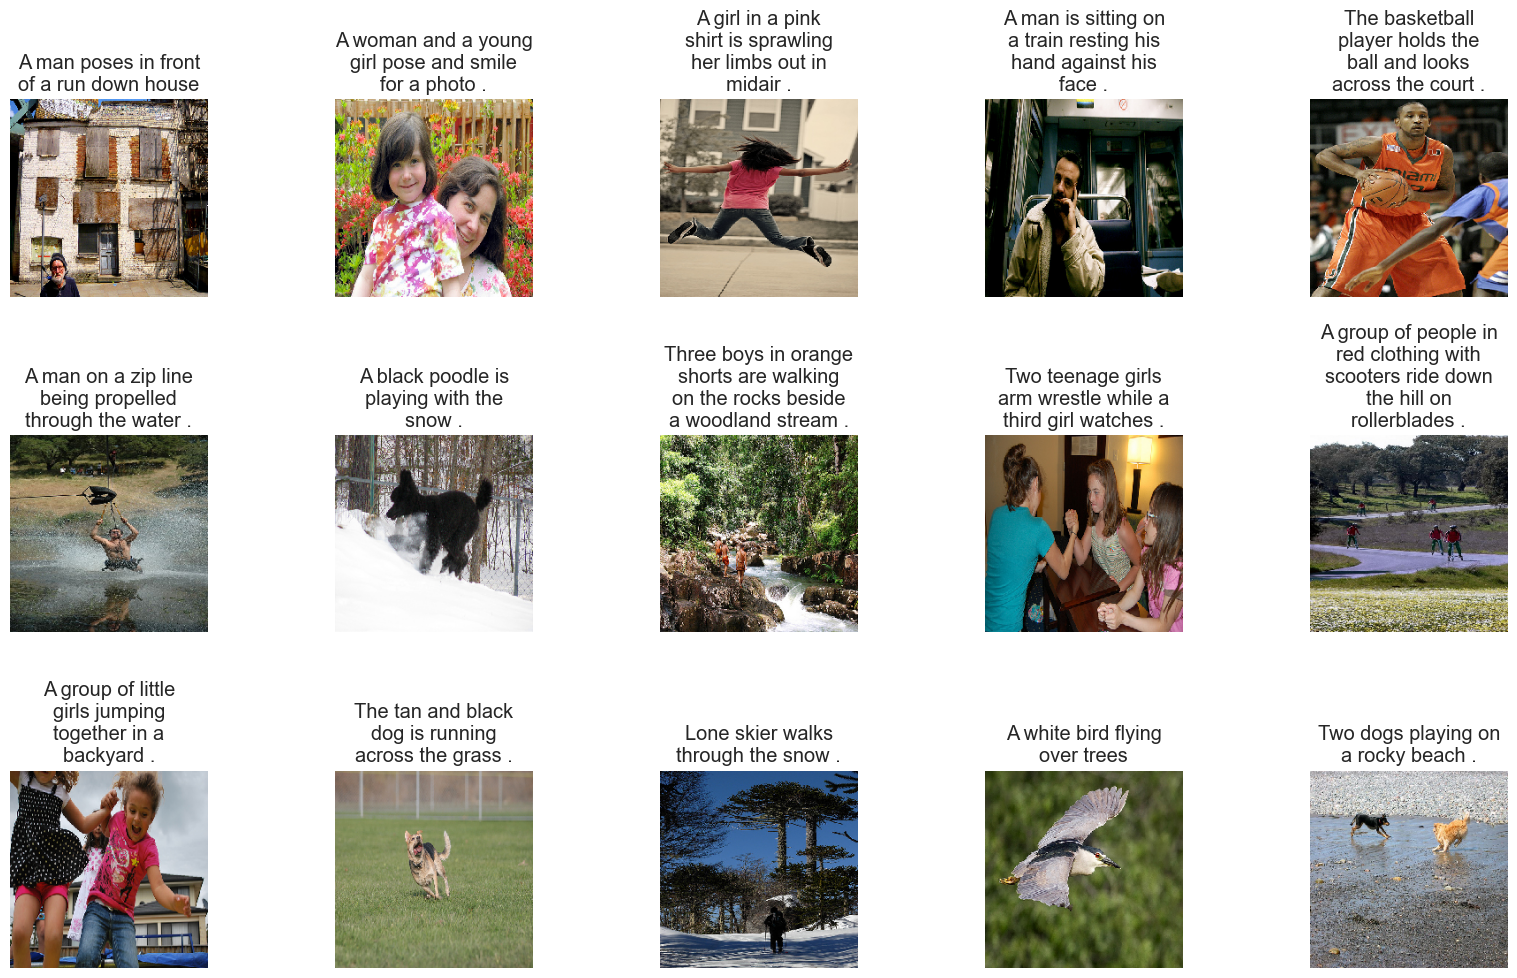

In [7]:
display_images(data.sample(15))

## Caption Text Preprocessing Steps

1. **Convert sentences into lowercase**  
   Ensure all text is in lowercase to maintain uniformity.

2. **Remove special characters and numbers**  
   Eliminate characters like `!@#%&*()`, punctuation, and digits to focus on meaningful words.

3. **Remove extra spaces**  
   Replace multiple spaces with a single space and strip leading/trailing whitespace.

4. **Remove single characters**  
   Discard standalone letters which often do not add value to the meaning of the caption.

5. **Add starting and ending tags**  
   Insert special tokens such as `<start>` at the beginning and `<end>` at the end of each sentence to clearly define sentence boundaries.


In [8]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

Preprocessed Text

In [9]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## Tokenization and Encoded Representation

1. **Tokenization**  
   Each sentence is split into individual words (tokens). For example:  
   `"a dog is running"` → `["a", "dog", "is", "running"]`

2. **One-Hot Encoding**  
   Each token is converted into a one-hot encoded vector — a binary vector where only one element is `1` (indicating the word's index in the vocabulary), and all others are `0`.  
   Example for a vocabulary size of 5:  
   `"dog"` → `[0, 1, 0, 0, 0]`

3. **Embedding Layer**  
   These one-hot vectors are then passed through an **embedding layer** to transform them into dense, continuous vector representations (word embeddings), which capture semantic relationships between words.

   Example:  
   One-hot `[0, 1, 0, 0, 0]` → Embedding `[0.25, -0.13, 0.67, ...]`


In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

## Image Feature Extraction

1. **Architecture Used: DenseNet201**  
   The **DenseNet201** model is utilized to extract deep features from input images. This model is known for its efficiency and dense connectivity between layers.

2. **Alternative Architectures**  
   Other pretrained CNN architectures such as **ResNet**, **Inception**, or **VGG** can also be used for feature extraction depending on the application and performance requirements.

3. **Global Average Pooling (GAP) Layer**  
   The final layer used in DenseNet201 is the **Global Average Pooling (GAP)** layer. Instead of using fully connected layers, GAP reduces each feature map to a single number by taking the average.

4. **Image Embedding Size**  
   Since GAP is used at the end of the DenseNet201, the output for each image is a **1920-dimensional vector**, which serves as the image embedding.



In [11]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


100%|██████████| 8091/8091 [20:16<00:00,  6.65it/s]  


## Data Generation

1. **Why Data Generation is Needed**  
   Training an Image Captioning model, like any deep learning model, is computationally intensive. Loading the entire dataset into memory is not feasible due to limited resources.  
   **Solution:** Generate data **batch-wise** during training to efficiently manage memory usage.

2. **Batch-wise Data Preparation**  
   During training, data is processed and fed to the model in batches. Each batch includes:
   - **Image Embeddings**: Precomputed feature vectors (e.g., 1920-dimensional vectors from DenseNet201).
   - **Caption Text Embeddings**: Tokenized and encoded versions of captions, aligned with the corresponding images.

3. **Training vs Inference Input**
   - **Training Time**: The full caption sequence (in embedded/tokenized form) is provided to the model along with the image embedding.
   - **Inference Time**: The model generates captions **word by word**. It starts with a `<start>` token and predicts the next word at each step, feeding its own previous prediction back into the model until it generates the `<end>` token.



In [12]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

## Modelling

1. **Initial Input to the Model**  
   The **image embedding** (e.g., 1920-dimensional vector from DenseNet201) is **concatenated** with the embedding of the first word of the caption — typically the special token `<start>`.

2. **Sequence Generation with LSTM**  
   This combined input is passed into an **LSTM (Long Short-Term Memory)** network. The LSTM is responsible for learning the temporal dependencies in the caption sequence.

3. **Word-by-Word Sentence Formation**  
   - The LSTM begins generating words **one at a time**.
   - At each time step, the previous word's embedding is input to the LSTM.
   - The model predicts the **next word** in the sequence until it generates the special `<end>` token, completing the sentence.



In [13]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [14]:
from tensorflow.keras.utils import plot_model

## Model Modification

A slight enhancement has been made to the original architecture proposed in the 2014 paper:  
**"Show and Tell: A Neural Image Caption Generator"**  
([arXiv:1411.4555](https://arxiv.org/pdf/1411.4555.pdf))

### Key Modification:

- Instead of just feeding the image embeddings at the beginning of the LSTM,  
  **we add the image feature embedding to the output of the LSTM** at each time step.
- This **fused representation** (LSTM output + image features) is then passed to the **fully connected (Dense) layers** responsible for word prediction.

### Why This Helps:

- This allows the model to **retain visual context throughout the sentence generation**, not just at the start.
- It leads to a **slight performance boost**, especially for more complex or ambiguous scenes where continuous visual grounding helps.


In [18]:
caption_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    491,776 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 256)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  2,172,160 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 35, 256)   │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dropout[0][0],    │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8485)      │  1,094,565 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,316,709 (16.47 MB)

 Trainable params: 4,316,709 (16.47 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [22]:
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [23]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - loss: 3.9924
Epoch 1: val_loss improved from inf to 3.79745, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 321s 599ms/step - loss: 3.9923 - val_loss: 3.7975 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - loss: 3.8176
Epoch 2: val_loss improved from 3.79745 to 3.71842, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 211s 388ms/step - loss: 3.8176 - val_loss: 3.7184 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 3.6920
Epoch 3: val_loss improved from 3.71842 to 3.66523, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 111s 207ms/step - loss: 3.6920 - val_loss: 3.6652 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 3.5866
Epoch 4: val_loss improved from 3.66523 to 3.65161, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 116s 216ms/step - loss: 3.5866 - val_loss: 3.6516 - learning_rate: 0.0

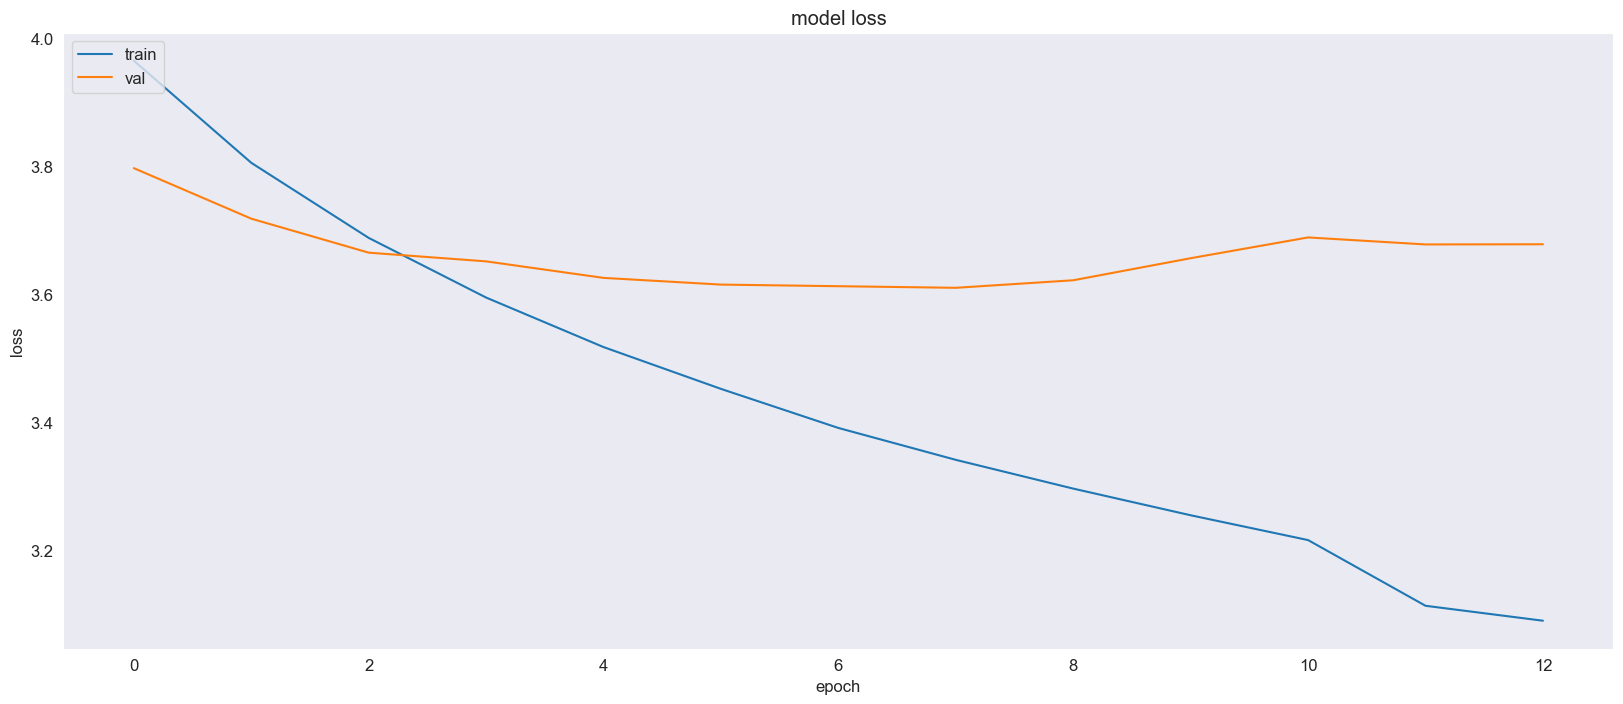

In [24]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Caption Generation Utility Functions

These utility functions are used during the **inference phase** to generate captions for input images.

At the start of the generation process, the **image embedding** is passed to the model along with the **initial start token** (`<start>`).  
Subsequently, the model predicts one word at a time, and the **embedding of each newly predicted word** is fed back into the model to predict the next word.  
This process continues until the **end token** (`<end>`) is generated or a predefined maximum caption length is reached.


In [25]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [26]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

In [27]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [28]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━

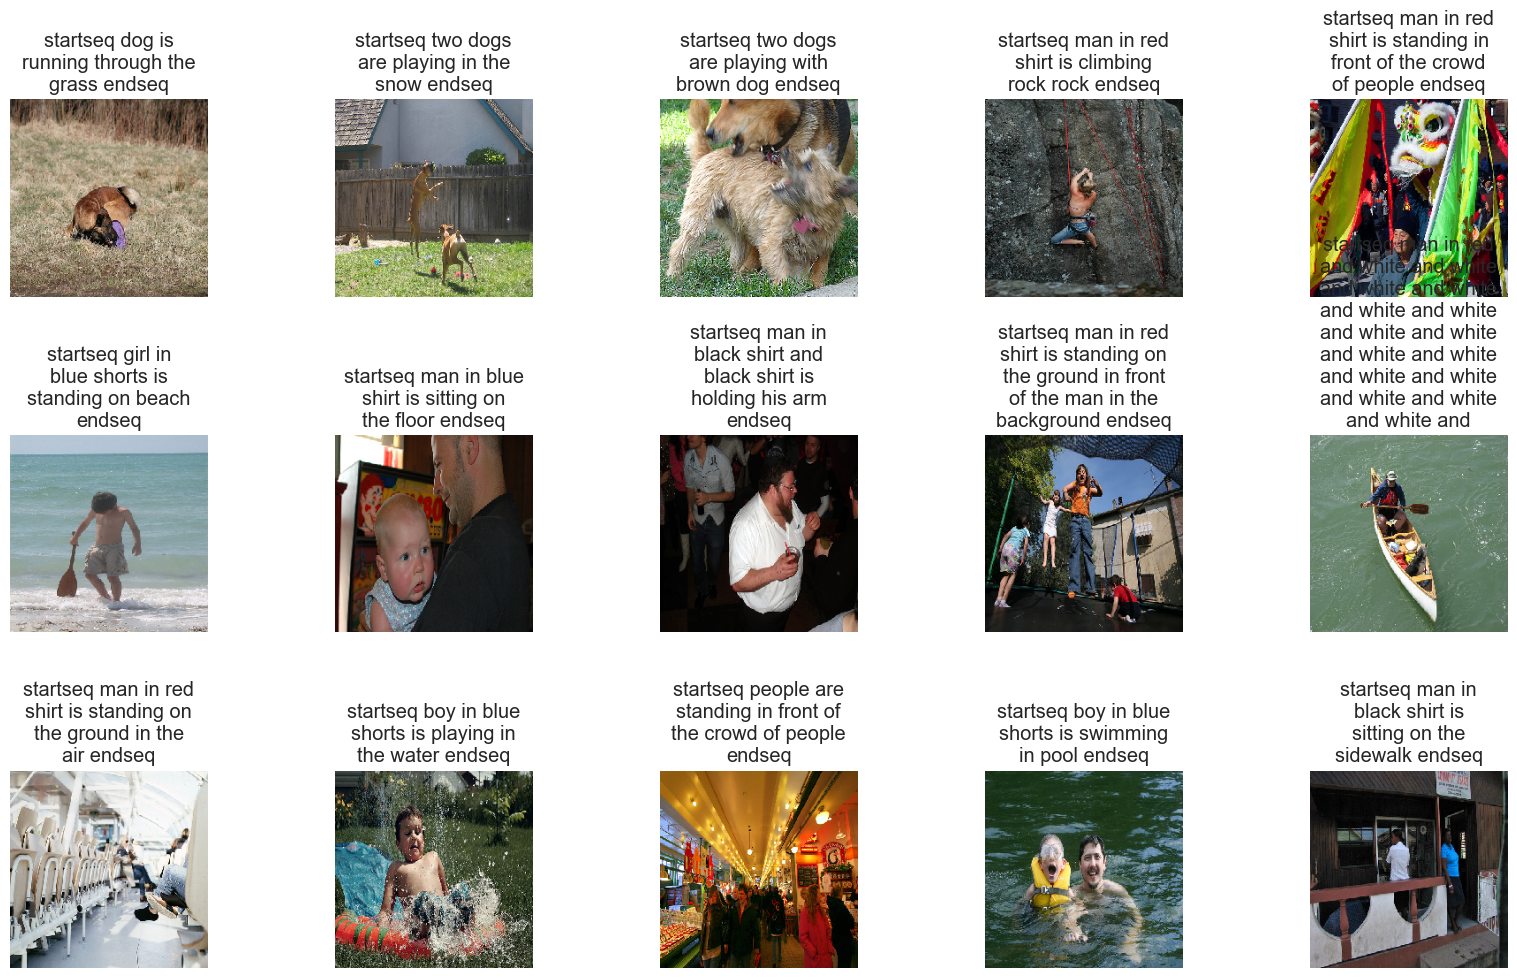

In [29]:
display_images(samples)

In [30]:
from tensorflow.keras.models import load_model

# Load the best saved model
caption_model = load_model("model.keras")

In [31]:
def generate_caption(image_array, model, tokenizer, max_length, feature_extractor):
    # Preprocess image and extract features
    image_array = cv2.resize(image_array, (224, 224)) / 255.0
    image_array = np.expand_dims(image_array, axis=0)
    image_features = feature_extractor.predict(image_array)  # shape: (1, 2048)

    in_text = "startseq"
    for _ in range(max_length):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_length)
        
        y_pred = model.predict([image_features, seq], verbose=0)
        y_pred = np.argmax(y_pred)
        word = idx_to_word(y_pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    
    return in_text.replace("startseq", "").replace("endseq", "").strip()


In [33]:
import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)